All configuration and model checks passed.
Database generation complete
[0.    0.025 0.05  0.075 0.1  ]
grid size in each layer before partitioning = [39.85153559 52.74261603]
Layer depths given by user before partitioning = [   0. 4000.] m
New layer depths after partitioning for computationional speed = [   0.   50.  450. 4000.] m
New gridSize after partioning = [39.85153559 39.85153559 39.85153559]
Total number of layers = 3
Doing realization = 0
<Layer z: 0.0-50.0, type: no_intersection, nblocks: 1>
Block = 1
Integrating volume  NN block in layer0
Integrating vertical surface NN block in layer0
vertical boundary face found
Integrating vertical surface NN block in layer0
vertical boundary face found
Integrating vertical surface NN block in layer0
vertical boundary face found
Integrating vertical surface NN block in layer0
vertical boundary face found
Integrating horizontal surface NN block in layer0
Horizontal face found
Horizontal face found
<Layer z: 50.0-450.0, type: contains, nbl

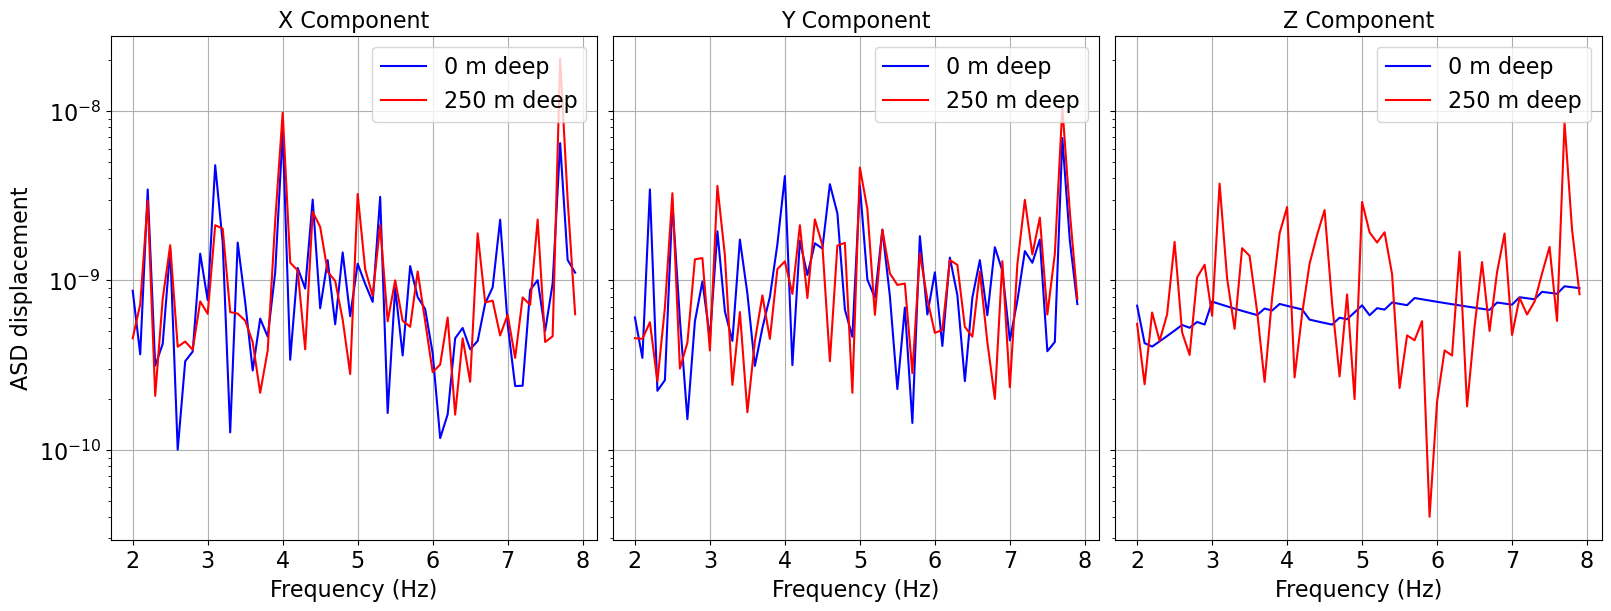

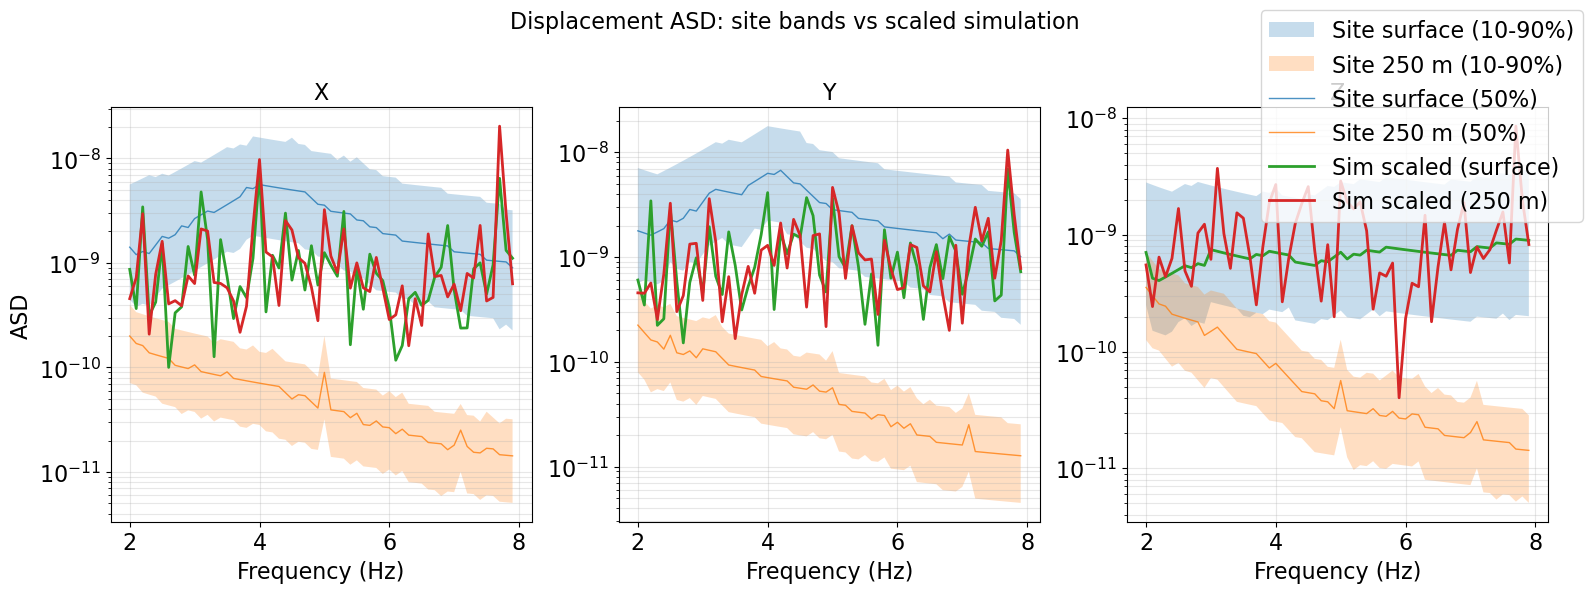

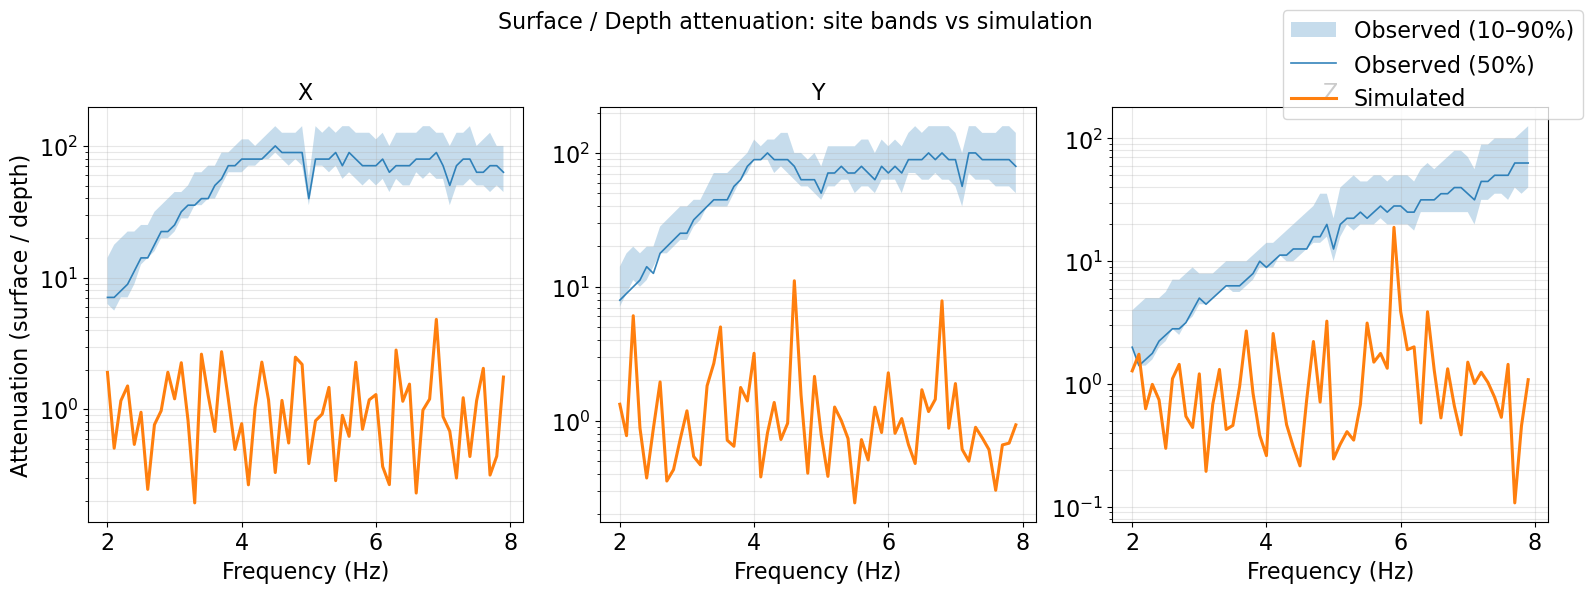

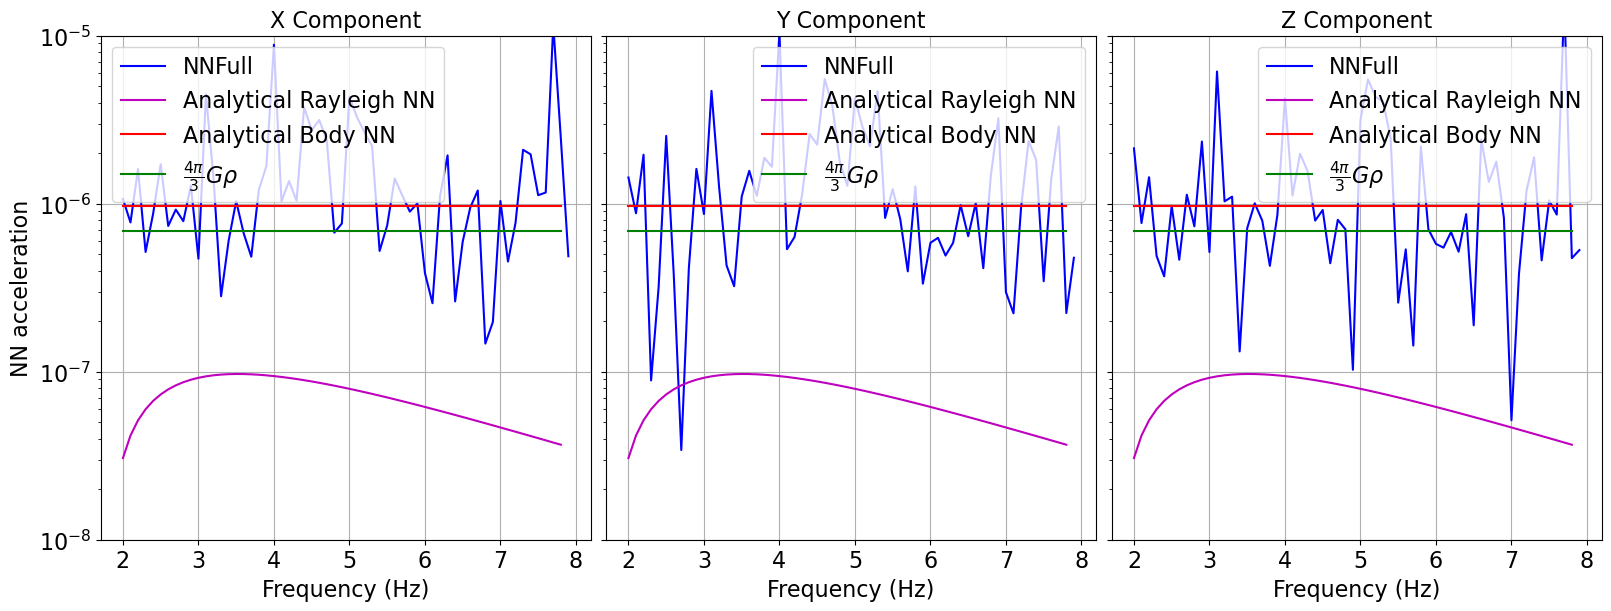

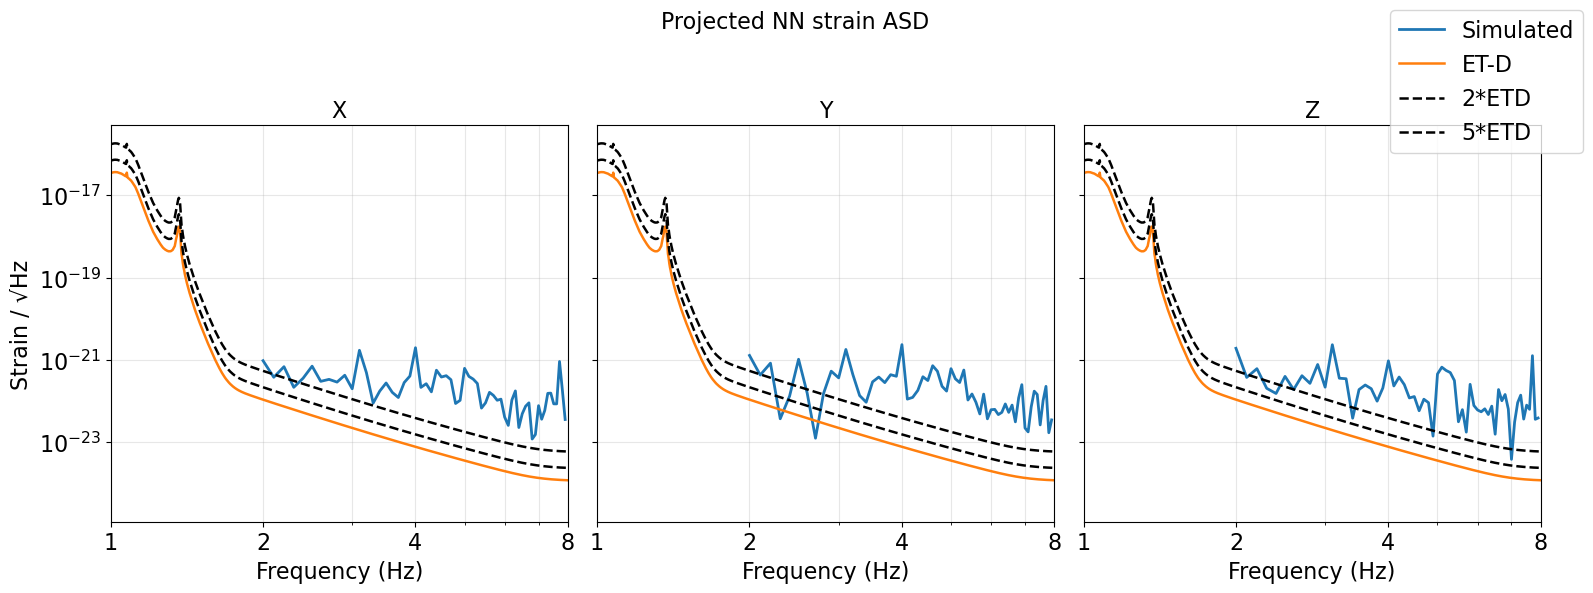

In [2]:
# script for computing NN for any layered model
import numpy as np
import os
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.io import savemat
from scipy.io import loadmat
import scipy.constants as const
from pysurf96 import surf96
from modules import configLoader
from modules import validateInputs
from modules import createDB
from modules import NNGeometryN
from modules import simDisp
from modules import NNCompute
from modules import NNPP
from modules import plotUtils

def main():

    # load the config file
    configFile="/home/koley/Results/FullRunConfig/configParseBody.ini"
    config = configLoader.load_config(configFile)
    validateInputs.validateInputs(config)
    
    #splitAll = createDB.createFinalInputs(config)

    #print(f"Prepared {splitAll.shape[0]} total runs")
    #print(f"Cores available: {config.cpuCoresQseis}")

    #results = createDB.runMultiQseis(splitAll, config.inputPath, config.qseisExe, nWorkers = config.cpuCoresQseis)
    print("Database generation complete")
    
    # flag for pure Rayleigh wavefield in homogeneous half-space
    ifRay = config.ifRay

    # flag for plane P and S waves in homogeneous half space
    ifBody = config.ifBody

    # flag for wavefield simulation
    ifFullField = config.ifFullField

    saveHV = config.saveHV

    thickness = config.thickness # units in meters
    vs = config.vS # units in m/s
    vp = config.vP # units in m/s
    rho = config.rho # units in kg/m^3
    rhoAir = config.rhoAir # density of air
    fMin = config.fMin; fMax = config.fMax; df = config.df;# units in Hz
    lambdaFrac = config.lambdaFrac # fraction
    lambdaRes = config.lambdaRes; #must be greater than 4
    
    # given a cuboidal domain should be greater than sqrt of 
    xMaxGF = config.xMaxGF # maximum horizontal offset upto which displacements will be used
    zMaxGF = config.zMaxGF # maximum depth upto which displacements will be used
    maxRec = config.maxRec # same value of number of receivers that qseis can handle in one go check qsglobal.h
    
    xMin = -config.xExtent; xMax = config.xExtent # minimum and maximum of the simulation domain in X-direction (EW)
    yMin = -config.yExtent; yMax = config.yExtent # maximum and minimum of the simulation domain in Y-direction (NS)
    zMin = 0.0; zMax = config.zExtent # maximum and minimum of the simulation domain in Z-direction (depth)

    # check if the GFs are generated up to correct hoizontal offsets
    xDiag = (xMax-xMin)*np.sqrt(2); yDiag = (yMax-yMin)*np.sqrt(2);
    if(xMaxGF<xDiag or xMaxGF<yDiag):
        raise ValueError("xMaxGF must be >= sqrt(2)x(xMax-xMin) and sqrt(2)x(yMax-yMin)")

    if(zMaxGF<zMax):
        raise ValueError("zMaxGF must be greater >= zMax")
        
    domXYBounds = (xMin,xMax,yMin,yMax)
    cubeC = config.cavityDepth; rCavity = config.cavityRadius
    cubeS = 2*rCavity
    cubeTop = cubeC-cubeS; cubeBot = cubeC+cubeS
    
    G = const.G
    
    # some other inputs for simDisp
    maxRec = config.maxRec; # same value of number of receivers that qseis can handle in one go check qsglobal.h
    tMax = config.tMax; nSamp = config.nSamp
    
    # specify the folder where you want to write all input files, should have rw access
    # fInpPath is the path where the Green's function database exists
    fInpPath = config.inputPath #like "/data/gravwav/koley/QseisInpN/"
    #fInpPath = "/data/gravwav/koley/SALVUSOut/"

    # outDispPath should have rw access and is used for saving temp displacementy files
    outDispPath = config.outDispPath # like "/data/gravwav/koley/OutDisp/"

    # saves the NN and displacement values per realization
    outDispRea = config.outDispPathRea # like "/data/gravwav/koley/OutDispRea/"
    
    # GF components to be used
    components = ['fh-2.tz', 'fh-2.tr', 'fh-2.tt', 'fz-2.tz', 'fz-2.tr']

    # splitAll is necessary so load it
    nRea = config.nRea # number of realizations

    # this file is created at the time of database generation
    splitFileName = fInpPath + 'splitAll.mat'
    splitMat = loadmat(splitFileName)
    splitAll = splitMat['splitAll']

    # source distribution parameters
    R1 = config.R1; R2 = config.R2
    nSrc = config.nSrc
    srcDistri = config.srcDistri
    scaleVH = config.scaleVH

    # number of CPUs to be used for displacement and NN simulation
    nCPUDisp = config.cpuCoresDisp
    nCPUNN = config.cpuCoresNN
    computeStrategy = config.computeStrategy

    # frequency axis to be used by simDisp
    freqOut, idxFreq, df_native = simDisp.getFreqGrid(tMax, nSamp, fMin, fMax, df)
    nFreq = len(freqOut)

    # in case only Rayleigh waves in homogeneous half space is used, Rayleigh wave phase velocity is needed
    if(ifRay):
        periods = 1/freqOut
        vR = surf96(thickness,vp,vs,rho,periods,wave="rayleigh",mode=1,velocity="phase",flat_earth=True)
    else:
        vR = None
    # two depth points for scaling, displacement saved per realization
    zList = [0.0,config.cavityDepth]
    
    # generate the grid size required
    gridSize = NNCompute.getGridSize(thickness,vp, vs, rho, fMin, fMax, lambdaFrac, lambdaRes)
    
    print('grid size in each layer before partitioning = ' + str(gridSize))
    
    # create the layers and partition
    layers, vp2, vs2, rho2, gridSize2 = NNGeometryN.createAllLayers(xMin, xMax, yMin, yMax, thickness,
                                                                     zMax,vp,vs,rho,gridSize,cubeTop,cubeBot)
    print('New gridSize after partioning = '+ str(gridSize2))

    print('Total number of layers = ' + str(len(layers)))
    nLayers = len(layers)
    
    for reaNo in range(0,nRea):
        print('Doing realization = ' +str(reaNo))
        # get the source distribution per realization
        xSrc, ySrc, azSrc, srcMeta =  simDisp.genAmbSrc(nSrc , mode = srcDistri, R1 = R1, R2 = R2, xMin=xMin, xMax=xMax, yMin=yMin,
                                           yMax=yMax, randomPhase=True, freqDependent=True, nFreq=nFreq, decoupledHV=config.decoupledHV,
                                           scaleVH = scaleVH)
        
        # in case the body wave in homogeneous half-space flag is turned on
        if(ifBody):
            metaBody = simDisp.genBodySrc(nSrc, nFreq, eP = 1/3, eS = 2/3)
        else:
            metaBody=None
        
        # create and save the displacement field on surface and depth for scaling afterwards
        if(ifRay):
            # uses ambient Rayleigh wavefield in homogeneous half space
            phiSrc = srcMeta["phiV"]; ampSrc = srcMeta["ämpV"]
            simDisp.getSurfDeepRayDispPerRea(zList, azSrc, phiSrc, ampSrc, outDispRea, reaNo, vR,
                                             vp2[0], vs2[0], freqOut=freqOut)
        elif(ifBody):
            # uses Plane P and S wave in homogeneous half space
            simDisp.getSurfDeepBodyDispPerRea(zList, metaBody, outDispRea, reaNo, vp2[0], vs2[0], freqOut=freqOut)
        
        else:
            # uses QSEIS full wavefield simulation instead
            simDisp.getSurfDeepDispPerRea(zList, xSrc, ySrc, azSrc, srcMeta, xMaxGF, splitAll, fMin, fMax, outDispRea,
                    fInpPath, components, reaNo, idxFreq = idxFreq, freqOut=freqOut)
        
        # preallocate per realization
        IBlockTot = np.zeros((nFreq,3),dtype=np.complex128)
        IVertFaceTot  = np.zeros((nFreq,3),dtype=np.complex128)
        IHorFaceTot = np.zeros((nFreq,3),dtype=np.complex128)
        ITot = np.zeros((nFreq,3),dtype=np.complex128)
        
        for layerNo, layer in enumerate(layers):
            layer = layers[layerNo]

            layer.updateCubeInteraction(cubeTop, cubeBot)
            layer.generateBlocks(xMin, xMax, yMin, yMax, cubeC, cubeS, domXYBounds)
   
            print(layer)
            blkNo = 1
            for blk in layer.blocks:
                #print(blk);
                print('Block = '+str(blkNo))
                print('Integrating volume  NN block in layer' + str(layerNo))
        
                IBlock = NNCompute.runVolNNComputeBlock(blk, gridSize2[layerNo], freqOut, cubeC, rCavity, xSrc, ySrc, azSrc,
                                              srcMeta, idxFreq, fMin, fMax, outDispPath, splitAll, xMaxGF,
                                              fInpPath, components, vR, useSimDisp=ifFullField, ifRay = ifRay, ifBody = ifBody,
                                              nCPUDisp=nCPUDisp, nCPUNN=nCPUNN, nChunk=20000,metaBody=metaBody,
                                              computeStrategy=computeStrategy,saveHV=saveHV)

                IBlockTot = IBlockTot + IBlock

                # now compute the surface NN from the vertical faces of the block which form the outer boundary
                for f in blk.verticalFaces:
                    if(f.isBoundary):
                        print('Integrating vertical surface NN block in layer' + str(layerNo))
                        print('vertical boundary face found')
                        # is an outer boundary
                        IVertFace = NNCompute.runVertSurfNNCompute(f, gridSize2[layerNo], freqOut, cubeC, xSrc, ySrc, azSrc,
                                                         srcMeta, idxFreq, fMin, fMax, outDispPath, splitAll,
                                                         xMaxGF, fInpPath, components, vR, nCPUDisp=1, nChunk = 20000, 
                                                         useSimDisp=ifFullField, ifRay = ifRay, ifBody = ifBody, vP_for_test=blk.vP,
                                                         vS_for_test=blk.vS, metaBody=metaBody,
                                                         computeStrategy=computeStrategy,saveHV=saveHV)
                        
                        IVertFaceTot = IVertFaceTot + IVertFace
        
                
                # now compute the surface NN from the horizontal interfaces at the very end of layers
                print('Integrating horizontal surface NN block in layer' + str(layerNo))
                IHorFace = NNCompute.handleHorSurfNN(layer, layers, blk, gridSize2[layerNo], nLayers, layerNo, rhoAir, freqOut, 
                                           cubeC, xSrc, ySrc, azSrc, srcMeta, idxFreq, fMin, fMax, outDispPath,
                                           splitAll, xMaxGF, fInpPath, components, vR, nCPUDisp=nCPUDisp,
                                           nCPUNN=nCPUNN, useSimDisp = ifFullField, ifRay = ifRay, ifBody = ifBody,
                                           vP_for_test=blk.vP, vS_for_test = blk.vS, metaBody = metaBody, chunk_size=20000,
                                           rCavity=rCavity, computeStrategy=computeStrategy, saveHV=saveHV)
                
                IHorFaceTot = IHorFaceTot + IHorFace
                
                blkNo = blkNo+1
    
        IVertFaceTot = IVertFaceTot*G
        IHorFaceTot = IHorFaceTot*G
        IBlockTot = IBlockTot*G
        ITot = (IBlockTot-IVertFaceTot-IHorFaceTot)
        # save the NN per realization
        nnFName = 'NNFullRea' + str(reaNo) + '.npz'
        np.savez(os.path.join(outDispRea, nnFName), IVertFaceTot = IVertFaceTot, IHorFaceTot = IHorFaceTot,
                 IBlockTot = IBlockTot, ITot = ITot, freqOut=freqOut)

    dispPointAllRea, attnAllRea, freqDisp = simDisp.assembleSurfDeepDispAllRea(outDispRea, zList, freqOut, nRea)
    nnAllRea, nnVolAllRea, nnSurfAllRea, fNN = NNCompute.assembleNNAllRea(outDispRea,freqOut, nRea)

    # preparing for output visualization
    plotUtils.set_plot_style(labelsize=16, ticksize=16, legendsize=16)
    
    ################################################################################################
    # scaling the surface and deep displacements
    scaledSimDisp, asdSurfX, asdSurfY, asdSurfZ, asdBHX, asdBHY, asdBHZ = NNPP.scaleDisp(
        dispPointAllRea, freqOut, config, scaleComp='Z', scaleDepth = 'surface', scaleToTrue=True)
    # make plot
    figDisp, axDisp = plotUtils.plotPSDDeepSurfMulti(freqOut, scaledSimDisp[:,:,0], '0 m deep', 'b', fig=None, axs=None, 
                                         quantity="ASD displacement")
    figDisp, axDisp = plotUtils.plotPSDDeepSurfMulti(freqOut, scaledSimDisp[:,:,1], '250 m deep', 'r', fig=figDisp, axs=axDisp, 
                                         quantity="ASD displacement")
    # compare the scaled simulated displacements to those observed at site
    figSh, axSh = plotUtils.plotScaledVsSiteASD(freqOut, scaledSimDisp, asdSurfX, asdSurfY, asdSurfZ,
                                                asdBHX, asdBHY, asdBHZ)
    ################################################################################################

    # compare simulated and site based attenuation between surface and depth
    attnSim, attnX, attnY, attnZ = NNPP.getAttn(dispPointAllRea,freqOut,config)
    figAttn, axAttn = plotUtils.plotAttn(freqOut, attnSim, attnX, attnY, attnZ)
    
    ################################################################################################
    # scale the simulated Newtonian acceleration such that displacement is set to 1
    scaledNN, *__ = NNPP.scaleNN(nnAllRea, dispPointAllRea, freqOut, config, scaleComp="Z", scaleDepth="surface",
                                 scaleToTrue=False)
    # plot the scaleNN
    figNN, axNN = plotUtils.plotPSDDeepSurfMulti(fNN, scaledNN, 'NNFull', 'b', fig=None, axs=None, 
                                         quantity="NN acceleration")
    NNRay,freqNNRay = NNCompute.getAnalyticRayNN(config)
    NNBody, minNN, freqNNBody = NNCompute.getAnalyticBodyNN(config,p=1/3)

    axNN[0].plot(freqNNRay, NNRay,'m',label='Analytical Rayleigh NN')
    axNN[1].plot(freqNNRay, NNRay,'m',label='Analytical Rayleigh NN')
    axNN[2].plot(freqNNRay, NNRay,'m',label='Analytical Rayleigh NN')

    axNN[0].plot(freqNNBody, NNBody,'r',label='Analytical Body NN')
    axNN[1].plot(freqNNBody, NNBody,'r',label='Analytical Body NN')
    axNN[2].plot(freqNNBody, NNBody,'r',label='Analytical Body NN')

    axNN[0].plot(freqNNBody, minNN,'g',label=r'$\frac{4\pi}{3} G \rho$')
    axNN[1].plot(freqNNBody, minNN,'g',label=r'$\frac{4\pi}{3} G \rho$')
    axNN[2].plot(freqNNBody, minNN,'g',label=r'$\frac{4\pi}{3} G \rho$')

    axNN[0].legend()
    axNN[1].legend()
    axNN[2].legend()

    axNN[0].set_ylim(10**-8,10**-5)
    axNN[1].set_ylim(10**-8,10**-5)
    axNN[2].set_ylim(10**-8,10**-5)

    ################################################################################################
    # compute scaleNN when the simulated displacement is scaled to match site ASD
    scaledNNToTrue, *__ = NNPP.scaleNN(nnAllRea, dispPointAllRea, freqOut, config, scaleComp="Z",
                                       scaleDepth="surface", scaleToTrue=True)
    nnProj, ETD = NNPP.NNProjectToET(scaledNNToTrue, fNN, config)

    figSens, axSens = plotUtils.plotNNStrainET(fNN, nnProj, ETD, title="Projected NN strain ASD", xlim=(1, 8), xscale="log",
                   yscale="log", comp_labels=("X", "Y", "Z"), sim_label="Simulated", etd_label="ET-D",
                   legend_once=True, fig=None,axs=None)

if __name__ == "__main__":
    main()

In [1]:
import os
print("OMP:", os.environ.get("OMP_NUM_THREADS"))
print("MKL:", os.environ.get("MKL_NUM_THREADS"))
print("OPENBLAS:", os.environ.get("OPENBLAS_NUM_THREADS"))
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
print("OMP:", os.environ.get("OMP_NUM_THREADS"))
print("MKL:", os.environ.get("MKL_NUM_THREADS"))
print("OPENBLAS:", os.environ.get("OPENBLAS_NUM_THREADS"))

OMP: None
MKL: None
OPENBLAS: None
OMP: 1
MKL: 1
OPENBLAS: 1
